In [1]:
import torch
from torch import nn
import pybuda
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("dyllanesl/ASL_Classifier")
model = AutoModelForImageClassification.from_pretrained("dyllanesl/ASL_Classifier")

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
tt0 = pybuda.TTDevice(
    name="tt_device_0",  # here we can give our device any name we wish, for tracking purposes
    arch=pybuda.BackendDevice.Grayskull
)

In [4]:
# Create module
pybuda_module = pybuda.PyTorchModule(
    name = "asl_model",  # give the module a name, this will be used for tracking purposes
    module=model  # specify the model that is being targeted for compilation
)

# Place module on device
tt0.place_module(module=pybuda_module)

In [5]:
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset('raulit04/ASL_Dataset1')['train']

Using custom data configuration raulit04--ASL_Dataset1-d033ce9363c88848
Reusing dataset parquet (/home/user/.cache/huggingface/datasets/raulit04___parquet/raulit04--ASL_Dataset1-d033ce9363c88848/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)
100%|██████████| 1/1 [00:00<00:00, 490.45it/s]


In [6]:
# Create a mapping from labels to IDs
label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

label_to_id = {label: idx for idx, label in enumerate(label_list)}
id_to_label = {idx: label for idx, label in enumerate(label_to_id)}

In [7]:
import os
compiler_cfg = pybuda.config._get_global_compiler_config()
compiler_cfg.balancer_policy = "Ribbon"
compiler_cfg.default_df_override = pybuda.DataFormat.Float32


In [8]:
def setup_image(image: Image):
    image.convert("RGB")
    processed_tensor = processor(images=image, return_tensors='pt')
    return processed_tensor['pixel_values']

In [9]:
def get_prediction_given_tensor(input_tensor):
    tt0.push_to_inputs((input_tensor,))
    output_q = pybuda.run_inference()
    output = output_q.get()
    output_tensor = output[0].value()
    pred = output_tensor.argmax(-1).item()
    return id_to_label[pred]

In [10]:
image_0 = Image.open(str(Path(os.path.abspath('.')) / 'cropped_tenstorrent_images' / '1.png'))
image_tensor = setup_image(image_0)

In [11]:

tt0.push_to_inputs((image_tensor,))
output_q = pybuda.run_inference()
output = output_q.get()

2024-08-03 04:47:04.670 | INFO     | Backend         - initialize_child_process called on pid 752500


/usr/local/lib/python3.8/dist-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/lib/python3.8/dist-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/usr/local/lib/python3.8/dist-packages/transformers/modeling_utils.py:4481: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/vit/modeling_vit.py:164: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values

2024-08-03 04:47:29.746 | INFO     | Backend         - initialize_child_process called on pid 753010


2024-08-03 04:47:30.070 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage post_initial_graph_pass
2024-08-03 04:47:30.668 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage consteval_graph
2024-08-03 04:47:30.742 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage optimized_graph
2024-08-03 04:47:31.094 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage post_autograd_pass
2024-08-03 04:47:31.207 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage pre_lowering_pass
2024-08-03 04:47:31.332 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage buda_graph_pre_placer


2024-08-03 04:47:31.524 | INFO     | GraphCompiler   - Running with Automatic Mixed Precision Level = 0.
2024-08-03 04:47:31.634 | INFO     | Always          - Running Balancer with Policy: PolicyType::Ribbon


2024-08-03 04:47:31.625 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage balancer_pass


2024-08-03 04:47:41.195 | INFO     | Balancer        - Starting Ribbon balancing
2024-08-03 04:47:42.382 | INFO     | Balancer        - Balancing 6% complete.
2024-08-03 04:47:43.266 | INFO     | Balancer        - Balancing 9% complete.
2024-08-03 04:47:43.960 | INFO     | Balancer        - Balancing 11% complete.
2024-08-03 04:47:44.699 | INFO     | Balancer        - Balancing 17% complete.
2024-08-03 04:47:45.005 | INFO     | Balancer        - Balancing 18% complete.
2024-08-03 04:47:45.291 | INFO     | Balancer        - Balancing 18% complete.
2024-08-03 04:47:46.638 | INFO     | Balancer        - Balancing 25% complete.
2024-08-03 04:47:47.312 | INFO     | Balancer        - Balancing 27% complete.
2024-08-03 04:47:47.583 | INFO     | Balancer        - Balancing 27% complete.
2024-08-03 04:47:48.882 | INFO     | Balancer        - Balancing 33% complete.
2024-08-03 04:47:49.520 | INFO     | Balancer        - Balancing 36% complete.
2024-08-03 04:47:49.775 | INFO     | Balancer       

2024-08-03 04:48:04.837 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage pre_netlist_pass
2024-08-03 04:48:05.077 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage generate_netlist
2024-08-03 04:48:05.077 | INFO     | pybuda.compile:generate_netlist:1075 - Generating Netlist
2024-08-03 04:48:05.786 | INFO     | pybuda.ci:create_symlink:89 - Symlink created from /home/user/tt-hackathon-2024/asl_model_netlist.yaml to /tmp/user/5813a89a0bf2/asl_model_netlist.yaml
2024-08-03 04:48:10.011 | INFO     | pybuda.compile:pybuda_compile_from_context:239 - Running compile stage backend_golden_verify
2024-08-03 04:48:10.019 | DEBUG    | pybuda.tensor:consteval_tensor:1233 - ConstEval graph: input_1_multiply_24
2024-08-03 04:48:10.022 | DEBUG    | pybuda.tensor:consteval_tensor:1233 - ConstEval graph: input_1_multiply_76
2024-08-03 04:48:10.023 | DEBUG    | pybuda.tensor:consteval_tensor:1233 - ConstEval graph: input_1_multiply_128

2024-08-03 04:48:10.313 | INFO     | Runtime         - Running tt_runtime on host: 'code-server-0dd1fffb-deployment-7cf49948d5-xw7jz'
2024-08-03 04:48:10.313 | INFO     | PerfInfra       - Backend profiler is disabled
2024-08-03 04:48:10.313 | INFO     | PerfInfra       - Memory profiler is enabled
2024-08-03 04:48:10.872 | WARNING  | Runtime         - Config.soc_descriptor_path='/tmp/user/5813a89a0bf2/device_descs/grayskull_2176_0x0.yaml' doesn't exist, defaulting to '/usr/local/lib/python3.8/dist-packages/budabackend/device/grayskull_10x12.yaml'
2024-08-03 04:48:10.893 | INFO     | SiliconDriver   - Detected 1 PCI device : {13}
2024-08-03 04:48:11.921 | INFO     | Runtime         - Compiling Firmware for TT device
2024-08-03 04:48:24.253 | INFO     | Runtime         - Starting device status monitor with TIMEOUT=500s
2024-08-03 04:48:24.253 | INFO     | Loader          - Waiting for 30 seconds for NCRISC Firmware to start running on 1 device(s)


2024-08-03 04:48:24.278 | INFO     | pybuda.backend:feeder_thread_main:149 - Feeder thread on <pybuda.backend.BackendAPI object at 0x7f8fb6b68910> starting
2024-08-03 04:48:24.278 | DEBUG    | pybuda.backend:push_constants_and_parameters:480 - Pushing to constant lc.input_tensor.concatenate_4.dc.sparse_matmul.4.0
2024-08-03 04:48:24.279 | DEBUG    | pybuda.backend:push_constants_and_parameters:480 - Pushing to constant lc.input_tensor.concatenate_4.dc.sparse_matmul.4.1
2024-08-03 04:48:24.279 | DEBUG    | pybuda.backend:push_constants_and_parameters:480 - Pushing to constant lc.input_tensor.layernorm_7.dc.reduce_sum.0.0
2024-08-03 04:48:24.279 | DEBUG    | pybuda.backend:push_constants_and_parameters:480 - Pushing to constant dc.input_tensor.layernorm_7.1
2024-08-03 04:48:24.280 | DEBUG    | pybuda.backend:push_constants_and_parameters:480 - Pushing to constant lc.input_tensor.layernorm_7.dc.reduce_sum.5.0
2024-08-03 04:48:24.280 | DEBUG    | pybuda.backend:push_constants_and_parameter

2024-08-03 04:48:25.118 | INFO     | SiliconDriver   - Detected 1 PCI device : {13}
2024-08-03 04:48:25.159 | INFO     | Runtime         - Running program 'run_fwd_0' with params [("$p_loop_count", "1")]


2024-08-03 04:48:25.157 | DEBUG    | pybuda.device:run_next_command:429 - Received RUN_FORWARD command on TTDevice 'tt_device_0' / 753010
2024-08-03 04:48:25.157 | DEBUG    | pybuda.ttdevice:forward:906 - Starting forward on TTDevice 'tt_device_0'
2024-08-03 04:48:25.158 | DEBUG    | pybuda.backend:feeder_thread_main:171 - Run feeder thread cmd: fwd
2024-08-03 04:48:25.160 | DEBUG    | pybuda.backend:read_queues:345 - Reading output queue asl_model.output_add_636
2024-08-03 04:48:25.161 | DEBUG    | pybuda.device_connector:pusher_thread_main:163 - Pusher thread pushing tensors
2024-08-03 04:48:25.162 | DEBUG    | pybuda.backend:push_to_queues:452 - Pushing to queue pixel_values
2024-08-03 04:48:25.192 | DEBUG    | pybuda.backend:read_queues:415 - Done reading queues
2024-08-03 04:48:25.193 | DEBUG    | pybuda.backend:pop_queues:421 - Popping from queue asl_model.output_add_636


In [12]:
output[0].value()

tensor([[ 1.3047, -1.3203, -1.2656,  0.7070,  0.9531,  1.2109,  0.5469, -0.4570,
         -0.3672, -0.1797, -0.3965, -0.2461,  1.5703,  0.4512, -0.2852, -1.3359,
          1.3125,  2.2500, -1.3203, -0.5195,  0.1621,  1.2500, -0.7344, -1.2031,
         -0.4453, -2.1094]], dtype=torch.bfloat16, requires_grad=True)

In [13]:
output[0].value().argmax().item()

17

In [14]:
id_to_label[output[0].value().argmax().item()]

'R'

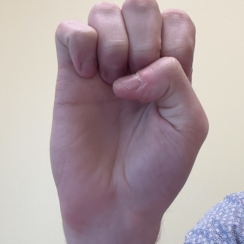

In [15]:
display(image_0)

In [16]:
def get_all_file_abspaths(directory):
    files = sorted([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])
    return [os.path.abspath(os.path.join(directory, f)) for f in files]

In [ ]:
output_letters = []
output_images = []
#going through the hand made dataset
for image_path in get_all_file_abspaths(str(Path(os.path.abspath('.')) / 'cropped_tenstorrent_images')):
    image = Image.open(image_path)
    output_images.append(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    output_letters.append(guessed_label)

In [ ]:
for (letter, image) in zip(output_letters, output_images):
    print('Guessed letter:', letter)
    print('Image')
    display(image)

In [ ]:
print('desired word: ', 'Tenstorrent')
print('Guessed word: ', ''.join(output_letters))

In [ ]:
#going through the hugging face dataset
dataset_length = len(dataset['image'])
correct = 0
for i, (image, label) in enumerate(zip(dataset['image'], dataset['label'])):
    if i == 0:
        print('image: ')
        display(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    
    if i < 5:
        print('actual label: ', label, ' guessed label: ', guessed_label)
    if i ==5:
        print("you get the deal. I'll just print out the accuracy")
    correct += 1 if label == guessed_label else 0
    # break

print('accuracy: ', correct/dataset_length)

In [ ]:
output_letters = []
output_images = []
#going through the cherry picked dataset
for image_path in get_all_file_abspaths(str(Path(os.path.abspath('.')) / 'dataset_tenstorrent_images')):
    image = Image.open(image_path)
    output_images.append(image)
    readied_tensor = setup_image(image)
    guessed_label = get_prediction_given_tensor(readied_tensor)
    output_letters.append(guessed_label)

2024-08-03 04:56:54.719 | INFO     | Runtime         - Reading debug mailbox for device 0, output yaml path /tmp/user/5813a89a0bf2/perf_results//debug_mailbox_device_0.yaml
2024-08-03 04:56:54.763 | ERROR    | Always          - Device runtime exceeded timeout of 500 seconds, a possible hang is detected. TT_BACKEND_TIMEOUT=<value> envvar can be used to increase the timeout.


terminate called after throwing an instance of 'tt::error_types::timeout_error'
  what():  Device runtime exceeded timeout of 500 seconds, a possible hang is detected.


In [ ]:
for (letter, image) in zip(output_letters, output_images):
    print('Guessed letter:', letter)
    print('Image')
    display(image)

In [19]:
print('desired word: ', 'Tenstorrent')
print('Guessed word: ', ''.join(output_letters))

desired word:  Tenstorrent
Guessed word:  TENSTORRENT


In [ ]:
pybuda.shutdown()

In [ ]:
tt0.remove_modules()